In [3]:
import string
import gc
import sklearn_crfsuite

import epam_nlp as hw
import seaborn as sns
import pandas as pd
import numpy as np

from pathlib import Path
from wordcloud import WordCloud
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV

sns.set_context('talk', rc={'figure.figsize': (22, 18)})
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [4]:
DATA = Path('../data')
PROCESSED = DATA / 'processed_voa.tsv'
CRF_FEATURES_PATH = DATA / 'crf_features_bin'
TARGET = 'iob_ner'
SEED = 42

# Data load

In [32]:
df = hw.load_data(PROCESSED)
df.head(10)

,token,pos,lemma,part,document,sentence,ner,iob_ner,seq
0,Thousands,NNS,thousand,p00,d0018,1,O,O,245
1,of,IN,of,p00,d0018,1,O,O,245
2,demonstrators,NNS,demonstrator,p00,d0018,1,O,O,245
3,have,VBP,have,p00,d0018,1,O,O,245
4,marched,VBN,march,p00,d0018,1,O,O,245
5,through,IN,through,p00,d0018,1,O,O,245
6,London,NNP,london,p00,d0018,1,geo,B-geo,245
7,to,TO,to,p00,d0018,1,O,O,245
8,protest,VB,protest,p00,d0018,1,O,O,245
9,the,DT,the,p00,d0018,1,O,O,245


# Simple EDA
## Tag distribution
### Tag itself

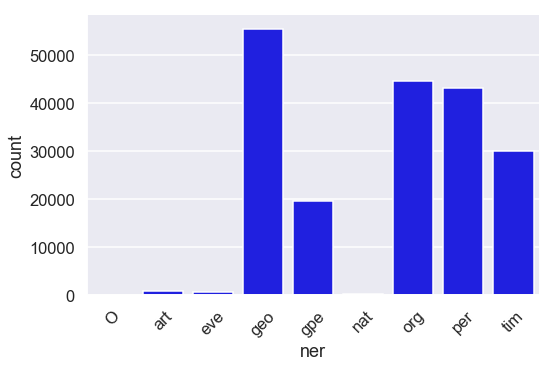

In [33]:
g = sns.catplot(x='ner', data=df[df.ner != 'O'], kind='count', aspect=1.5, color='b')
g.set_xticklabels(rotation=45);

### IOB-notation tags

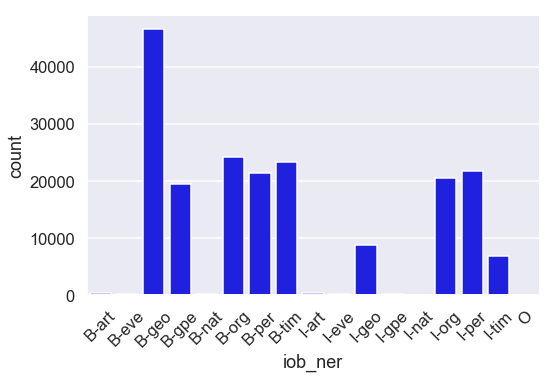

In [34]:
g = sns.catplot(x='iob_ner', data=df[df.ner != 'O'], kind='count', aspect=1.5, color='b')
g.set_xticklabels(rotation=45);

## Vocabulary overview

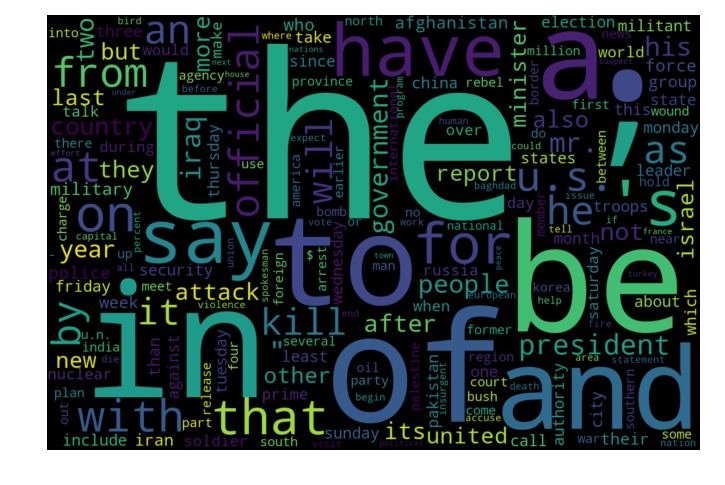

In [35]:
hw.get_wordcloud(df.lemma, SEED);

### Stop words removal

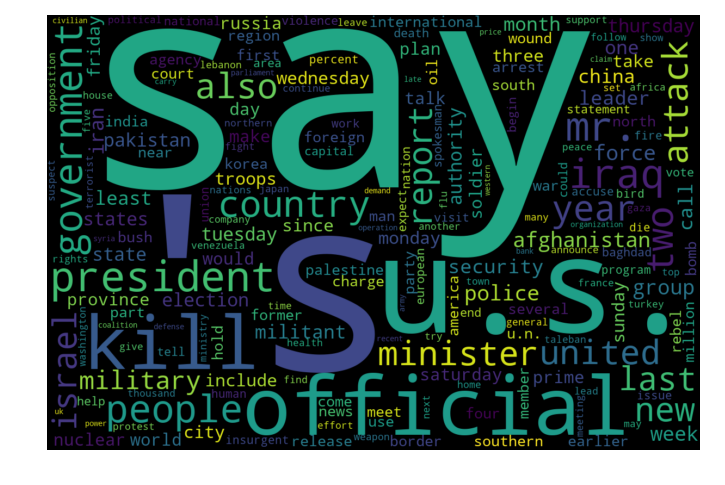

In [36]:
stopword_ind = hw.get_utility_token_index(df.lemma)
cleaned = df[~stopword_ind].reset_index(drop=True).copy()
hw.get_wordcloud(cleaned.lemma, SEED);

### Vocabulary size depending on token processing

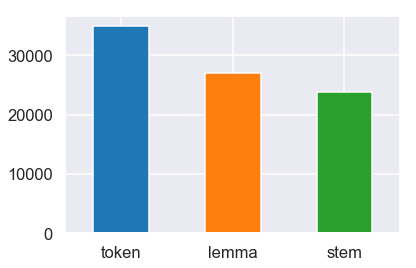

In [20]:
cleaned['stem'] = hw.get_stem(cleaned.lemma)
voc_size = pd.Series(data=np.array([len(cleaned.token.unique()), len(cleaned.lemma.unique()), len(cleaned.stem.unique())]), 
                     index=['token', 'lemma', 'stem'])
voc_size.plot(kind='bar', rot=0);

## POS-tags distribution over NER-tags

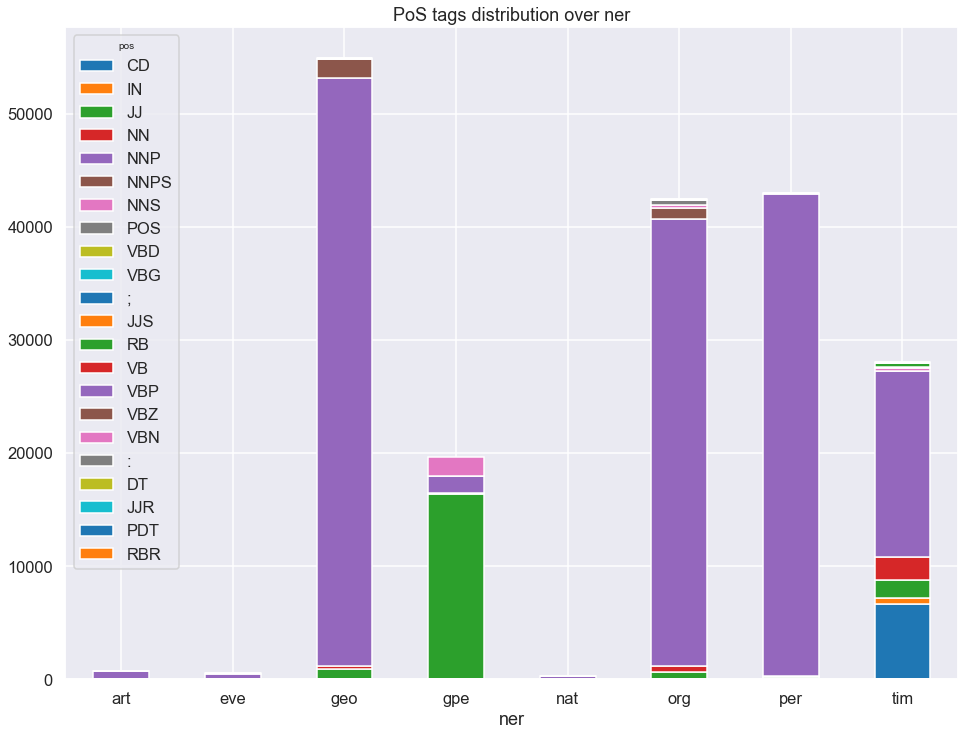

In [26]:
stacked_plot = cleaned[cleaned.ner != 'O'].groupby(['ner', 'pos']).size().reset_index().pivot(columns='pos', index='ner', values=0).fillna(0)
stacked_plot.plot(kind='bar', stacked=True, figsize=(16, 12), title='PoS tags distribution over ner', rot=0);

# Baseline model

## HMM

### Only token itself used as features

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

unknown_list = ['<UNK>']
class Mapping:
    def umap(self, x):
        return np.full_like(x, '<UNK>', dtype=object)

ohe = OneHotEncoder()
le = hw.UnknownWordsLabelEncoder(unknown_list, Mapping())
pipe = Pipeline([
    ('le', le),
    ('ohe', ohe)
])

In [29]:
X, y, lengths = hw.get_X_y_lengths(cleaned, cols_to_keep={'token'})

In [33]:
%%time
cv = hw.get_cv(lengths=lengths, seed=SEED, n_folds=11, yield_lengths=True)
scores = hw.hmm_cv(X, y, cv, cleaned.iob_ner, transformer=pipe, verbose=1)

Fold 1 score: 0.5274148802017654
Fold 2 score: 0.5350406988286679
Fold 3 score: 0.5273519610356319
Fold 4 score: 0.5312468141502701
Fold 5 score: 0.5179405574662492
Fold 6 score: 0.5307632195884345
Fold 7 score: 0.534394774443764
Fold 8 score: 0.5381420322155811
Fold 9 score: 0.5279550676538166
Fold 10 score: 0.5253167803827015
Fold 11 score: 0.5355963681386711
AVG cross-validation f1 score: 0.530105741282323


### Stem + PoS + shape

In [10]:
cleaned['shape'] = cleaned.token.map(hw.word_shape)

In [12]:
X, y, lengths = hw.get_X_y_lengths(cleaned, cols_to_keep={'stem', 'pos', 'shape'})

In [13]:
%%time
cv = hw.get_cv(lengths=lengths, seed=SEED, n_folds=11, yield_lengths=True)
scores = hw.hmm_cv(X, y, cv, cleaned.iob_ner, transformer=pipe, verbose=1)

Fold 1 score: 0.5024283911430647
Fold 2 score: 0.5101365486288082
Fold 3 score: 0.5096033728919426
Fold 4 score: 0.5173310561658192
Fold 5 score: 0.5082531214967723
Fold 6 score: 0.5076574247185648
Fold 7 score: 0.5098743267504489
Fold 8 score: 0.5138134409436598
Fold 9 score: 0.5089125865960924
Fold 10 score: 0.5019415967691829
Fold 11 score: 0.5125118035882908
AVG cross-validation f1 score: 0.5093148790629679
Wall time: 10min 16s


### Stem + PoS + shape + suffix + prefix

In [11]:
cleaned['prefix'] = cleaned['lemma'].str.slice(0, 3)
cleaned['suffix'] = cleaned['lemma'].str.slice(-3)

In [30]:
X, y, lengths = hw.get_X_y_lengths(cleaned, cols_to_keep={'stem', 'pos', 'shape', 'prefix', 'suffix'})

In [31]:
%%time
cv = hw.get_cv(lengths=lengths, seed=SEED, n_folds=11, yield_lengths=True)
scores = hw.hmm_cv(X, y, cv, cleaned.iob_ner, transformer=pipe, verbose=1)

Fold 1 score: 0.5772128060263654
Fold 2 score: 0.5946368540379954
Fold 3 score: 0.5771410328038951
Fold 4 score: 0.5855286684944571
Fold 5 score: 0.5756615433370306
Fold 6 score: 0.5861024717629727
Fold 7 score: 0.5837526959022287
Fold 8 score: 0.5840679850686998
Fold 9 score: 0.5800707500298103
Fold 10 score: 0.5764766880708331
Fold 11 score: 0.5809355409098216
AVG cross-validation f1 score: 0.5819624578585554
Wall time: 18min 12s


### Add previous context

In [21]:
cleaned.head()

,token,pos,lemma,part,document,sentence,ner,iob_ner,seq,shape,prefix,suffix,stem
0,Thousands,NNS,thousand,p00,d0018,1,O,O,245,Xxxxxxxxx,tho,and,thousand
1,demonstrators,NNS,demonstrator,p00,d0018,1,O,O,245,xxxxxxxxxxxxx,dem,tor,demonstr
2,marched,VBN,march,p00,d0018,1,O,O,245,xxxxxxx,mar,rch,march
3,London,NNP,london,p00,d0018,1,geo,B-geo,245,Xxxxxx,lon,don,london
4,protest,VB,protest,p00,d0018,1,O,O,245,xxxxxxx,pro,est,protest


In [23]:
shifted = cleaned \
            .groupby(['seq', 'sentence'])['shape', 'stem', 'pos', 'suffix', 'prefix'] \
            .shift(1) \
            .astype(object) \
            .fillna('<BOS>') \
            .astype('category')

In [26]:
with_prev = cleaned.join(shifted, rsuffix='_prev')
with_prev.sample(3)

,token,pos,lemma,part,document,sentence,ner,iob_ner,seq,shape,prefix,suffix,stem,shape_prev,stem_prev,pos_prev,suffix_prev,prefix_prev
520064,avoid,VB,avoid,p71,d0658,3,O,O,8936,xxxxx,avo,oid,avoid,xxxxxx,polic,NNS,ice,pol
693717,coal,NN,coal,p95,d0564,5,O,O,7585,xxxx,coa,oal,coal,xxxx,area,NN,rea,are
660046,independent,JJ,independent,p91,d0131,6,O,O,1806,xxxxxxxxxxx,ind,ent,independ,xxxxx,draw,VBN,raw,dra


In [27]:
X, y, lengths = hw.get_X_y_lengths(with_prev, cols_to_keep={'pos', 'shape', 'prefix', 'suffix', 'stem', 
                                                            'shape_prev', 'stem_prev', 'pos_prev', 'suffix_prev', 'prefix_prev'})
X[:5]

array([['NNS', 'Xxxxxxxxx', 'tho', 'and', 'thousand', '<BOS>', '<BOS>',
        '<BOS>', '<BOS>', '<BOS>'],
       ['NNS', 'xxxxxxxxxxxxx', 'dem', 'tor', 'demonstr', 'Xxxxxxxxx',
        'thousand', 'NNS', 'and', 'tho'],
       ['VBN', 'xxxxxxx', 'mar', 'rch', 'march', 'xxxxxxxxxxxxx',
        'demonstr', 'NNS', 'tor', 'dem'],
       ['NNP', 'Xxxxxx', 'lon', 'don', 'london', 'xxxxxxx', 'march',
        'VBN', 'rch', 'mar'],
       ['VB', 'xxxxxxx', 'pro', 'est', 'protest', 'Xxxxxx', 'london',
        'NNP', 'don', 'lon']], dtype=object)

In [37]:
%%time
cv = hw.get_cv(lengths=lengths, seed=SEED, n_folds=11, yield_lengths=True)
scores = hw.hmm_cv(X, y, cv, cleaned.iob_ner, transformer=pipe, verbose=1)

Fold 1 score: 0.6969292389853138
Fold 2 score: 0.7079574742268041
Fold 3 score: 0.7049887086840484
Fold 4 score: 0.7004544151962993
Fold 5 score: 0.6953677582893822
Fold 6 score: 0.7015257870623345
Fold 7 score: 0.704147617282425
Fold 8 score: 0.7061667691046917
Fold 9 score: 0.6997998938212113
Fold 10 score: 0.6952439777640519
Fold 11 score: 0.7048359740206014
AVG cross-validation f1 score: 0.7015834194942876
Wall time: 48min 5s


# CRF

In [27]:
features, y, labels = hw.load_crf_features(CRF_FEATURES_PATH)
lengths = np.ones(len(y))

In [10]:
features[1][1]

{'bias': 1.0,
 'pos': 'NNP',
 'shape': 'Xxxxxx',
 'stem': 'atom',
 'prev_lemma': 'international',
 'prev_shape': 'Xxxxxxxxxxxxx',
 'prev_pos': 'NNP',
 'next_lemma': 'energy',
 'next_shape': 'Xxxxxx',
 'next_pos': 'NNP'}

In [31]:
%%time
cv = hw.get_cv(lengths=lengths, seed=SEED, n_folds=11)
crf_scores = hw.crf_cv(features, y, cv=cv, n_jobs=4, verbose=50)
print(f"AVG cross-validation f1 score: {np.mean(crf_scores)}")

[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done   5 out of  11 | elapsed:  4.3min remaining:  5.2min
[Parallel(n_jobs=4)]: Done   6 out of  11 | elapsed:  4.3min remaining:  3.6min
[Parallel(n_jobs=4)]: Done   7 out of  11 | elapsed:  4.4min remaining:  2.5min
[Parallel(n_jobs=4)]: Done   8 out of  11 | elapsed:  4.6min remaining:  1.7min
[Parallel(n_jobs=4)]: Done   9 out of  11 | elapsed:  6.3min remaining:  1.4min
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:  6.3min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  11 out of  11 | elapsed:  6.3min finished
AVG cross-validation f1 score: 0.8028497698512577
Wall time: 6min 20s


### Fitted CRF explanation/analysis

In [33]:
crf = hw.get_crf()
crf.fit(features, y)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.01, c2=0.01,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [34]:
import eli5 

eli5.show_weights(crf, top=10)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.702,0.062,-2.942,0.492,-5.482,0.855,-4.595,0.954,-8.952,0.618,-7.792,1.401,-4.237,2.166,-6.661,1.447,-3.477
B-art,-0.776,2.929,5.477,-1.178,-3.006,-2.436,-4.502,-2.915,-7.109,-0.698,-1.627,-0.734,-6.651,-1.911,-3.666,-0.615,-4.546
I-art,-0.135,2.508,5.002,-1.866,-1.61,-1.522,-4.134,-2.977,-3.916,0.0,-1.208,-3.078,-4.009,-0.283,-2.859,-2.414,-3.905
B-eve,-1.546,-0.786,-1.872,0.529,5.371,-1.798,-4.451,-1.987,-5.22,-2.41,-2.653,-3.555,-5.257,-3.476,-3.826,-0.026,-5.382
I-eve,-0.045,-0.429,-1.546,-4.476,4.775,-0.671,-3.362,-1.594,-4.201,-0.187,-1.294,0.457,-4.003,-1.549,-3.143,-0.928,-7.511
B-geo,0.354,-2.453,-5.702,-1.349,-5.804,0.367,3.522,-1.543,-13.78,-1.539,-4.574,-0.084,-4.432,-0.973,-7.911,0.719,-3.219
I-geo,0.323,-0.298,-4.208,-6.675,-4.133,0.364,2.142,-1.273,-9.266,-0.86,-3.168,-0.293,-4.078,-0.329,-6.637,0.768,-3.2
B-gpe,1.04,-2.217,-4.052,-0.959,-7.755,-2.069,-5.512,0.571,3.224,-3.705,-3.568,-0.539,-3.75,-0.595,-7.575,-0.958,-5.326
I-gpe,0.115,-1.305,-0.754,-0.955,-1.498,-3.792,-5.371,-0.008,-1.566,0.0,-0.692,-1.673,-4.505,-0.563,-3.195,-0.073,-4.15
B-nat,-1.451,-1.458,-1.516,-0.699,-2.175,-2.894,-4.176,-2.553,-5.016,0.334,3.169,-4.662,-3.715,-3.971,-3.904,-2.119,-2.951


# NN